### Estimation of obesity levels based on eating habits and physical condition

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import statistics 
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [6]:
df= pd.read_csv(r'C:\Users\Maedeh\Downloads\ObesityDataSet_raw_and_data_sinthetic.csv')

In [7]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


The dataset contains 16 variables. 15 features:
Gender
Age
Height
Weight
Family History with Overweight
Attributes related with eating habits (6)
Attributes related with the physical condition (4)
1 target:
NObeyesdad, renamed NObesity
Another revelant information is that most of these variables are category, except for Age, Height and Weight.

we want to classify individuals according to their obesity level which will be named: NObesity
There are 7 variables:
Insufficient_Weight/
Normal_Weight/
Overweight_Level_I/
Overweight_Level_II/
Obesity_Type_I/
Obesity_Type_II/
Obesity_Type_III

### Data Cleaning

In [8]:
df_clean = df.dropna()
print(df_clean.shape, df.shape)

(2111, 17) (2111, 17)


#### there is no missing value in our dataset!

We will check if we have outliers for non-categorical variables(Age, Height and Weight) or not. The study has been done with subjects between 14 and 61, so there is not a problem with it.

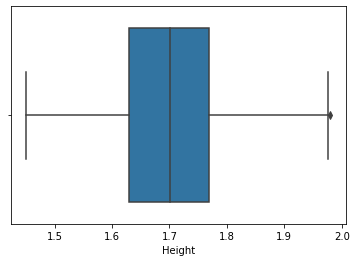

In [9]:
sns.boxplot(x=df['Height'])

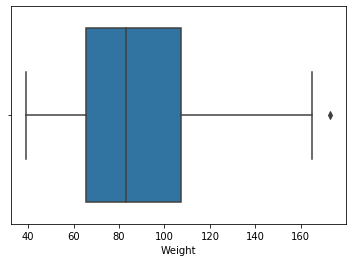

In [10]:
sns.boxplot(x=df['Weight'])

we will exclude the extreme values by using quantile values.

In [11]:
df_categorized = df.copy()

In [12]:
q1, q2 = df_categorized["Height"].quantile(q=0.25), df_categorized["Height"].quantile(q=0.75)
q3, q4 = df_categorized["Weight"].quantile(q=0.25), df_categorized["Weight"].quantile(q=0.75)

IQR1, IQR2 = q2-q1, q4-q3

#Height selection
df_categorized = df_categorized[df_categorized["Height"] >  q1 - 1.5*IQR1]
df_categorized = df_categorized[df_categorized["Height"] <  q2 + 1.5*IQR1]

#Weight selection
df_categorized = df_categorized[df_categorized["Weight"] >  q3 - 1.5*IQR2]
df_categorized = df_categorized[df_categorized["Weight"] <  q4 + 1.5*IQR2]

df_categorized.shape

(2109, 17)

3 lines were deleted.

In [13]:
df.describe().T.style.bar(subset=['mean'], color='#606ff2').background_gradient(subset=['std'], cmap='Blues').background_gradient(subset=['50%'], cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Age,2111,24.3126,6.34597,14,19.9472,22.7779,26,61
Height,2111,1.70168,0.0933048,1.45,1.63,1.7005,1.76846,1.98
Weight,2111,86.5861,26.1912,39,65.4733,83,107.431,173
FCVC,2111,2.41904,0.533927,1,2,2.3855,3,3
NCP,2111,2.68563,0.778039,1,2.65874,3,3,4
CH2O,2111,2.00801,0.612953,1,1.58481,2,2.47742,3
FAF,2111,1.0103,0.850592,0,0.124505,1,1.66668,3
TUE,2111,0.657866,0.608927,0,0,0.62535,1,2


In [14]:
target = pd.DataFrame(df_categorized, columns = ['NObeyesdad'])

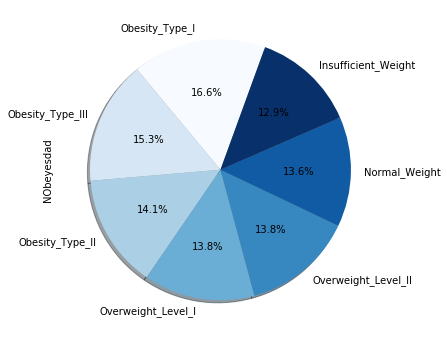

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
target['NObeyesdad'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, cmap="Blues", startangle=70)

In [16]:
list_var = ['Gender','family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for x in list_var:
    print(df_categorized[x].unique())

['Female' 'Male']
['yes' 'no']
['no' 'yes']
['Sometimes' 'Frequently' 'Always' 'no']
['no' 'yes']
['no' 'yes']
['no' 'Sometimes' 'Frequently' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']


In [17]:
dict_Gender = {'Female' : 0, 'Male' : 1}
dict_family_history_with_overweight = {'no' : 0, 'yes' : 1}
dict_FAVC = {'no' : 0, 'yes' : 1}
dict_CAEC = {'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3}
dict_SMOKE = {'no' : 0, 'yes' : 1}
dict_SCC = {'no' : 0, 'yes' : 1}
dict_CALC = {'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3}
dict_MTRANS = {'Public_Transportation' : 0, 'Walking' : 1, 'Automobile' : 2, 'Motorbike' : 3, 'Bike' : 4}
dict_NObeyesdad = {'Normal_Weight' : 0, 'Overweight_Level_I' : 1, 'Overweight_Level_II' : 2, 'Obesity_Type_I' : 3, 'Insufficient_Weight' : 4, 'Obesity_Type_II' : 5, 'Obesity_Type_III' : 6,}

In [18]:
for x in list_var:
    exec("df_categorized['"+ x +"'] = df_categorized['"+ x +"'].replace(dict_"+ x +")") #transformation for each string variable

df_categorized.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,0,Normal_Weight
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,0,Normal_Weight
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,0,Normal_Weight
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,1,Overweight_Level_I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,0,Overweight_Level_II


### Data Processing

In [19]:
df_features = df_categorized.drop(columns = 'NObeyesdad')

In [20]:
scaler = preprocessing.StandardScaler().fit(df_features)
df_scaled = pd.DataFrame(scaler.transform(df_features))
df_scaled['NObesity'] = df['NObeyesdad']
df_scaled.columns = df.columns.to_list()
df_scaled.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,-1.010966,-0.522851,-0.875432,-0.862561,0.472565,-2.75829,-0.784838,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,-1.187312,0.562347,-1.418188,-0.562843,Normal_Weight
1,-1.010966,-0.522851,-1.950036,-1.168884,0.472565,-2.75829,1.088434,0.404376,-0.29881,6.850680,1.619759,4.579165,2.339939,-1.079742,0.521474,-0.562843,Normal_Weight
2,0.989153,-0.207656,1.058855,-0.364787,0.472565,-2.75829,-0.784838,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,1.164189,0.562347,2.461135,-0.562843,Normal_Weight
3,0.989153,0.422733,1.058855,0.018116,-2.116110,-2.75829,1.088434,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,1.164189,-1.079742,2.461135,0.588501,Overweight_Level_I
4,0.989153,-0.365253,0.843934,0.125329,-2.116110,-2.75829,-0.784838,-2.165781,-0.29881,-0.145971,-0.012314,-0.218380,-1.187312,-1.079742,0.521474,-0.562843,Overweight_Level_II


In [21]:
df_scaled_features = df_scaled.drop(columns = 'NObeyesdad')
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled_features, df_scaled['NObeyesdad'], test_size=0.33)

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=3)
X_train = lda.fit_transform(X_train, Y_train)
X_test = lda.transform(X_test)

### KNN

In [23]:
%%time
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train,Y_train).predict(X_test)
pred_knn1 = knn1.predict(X_test)

Wall time: 53.9 ms


In [24]:
acc_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn1
print(acc_knn1.mean())
print(acc_knn1.std())

0.817544112559105
0.01038117331528369


In [25]:
precision_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn1
print(precision_knn1.mean())
print(precision_knn1.std())

0.8141213800151014
0.012749048501689295


In [26]:
recall_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn1
print(recall_knn1.mean())
print(recall_knn1.std())

0.8125367223382876
0.01114978038690552


In [27]:
f1_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn1
print(f1_knn1.mean())
print(f1_knn1.std())

0.8121174873364755
0.012229636626435614


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, pred_knn1))
print(classification_report(Y_test, pred_knn1))

[[ 85   9   2   0   1   1   0]
 [ 12  61   3   1   2  10   5]
 [  0   4 108   2   0   0   6]
 [  0   2   0  90   0   1   0]
 [  2   0   0   0 106   0   0]
 [  2  11   5   0   0  70  10]
 [  0   4   2   0   0  14  65]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.84      0.87      0.85        98
      Normal_Weight       0.67      0.65      0.66        94
     Obesity_Type_I       0.90      0.90      0.90       120
    Obesity_Type_II       0.97      0.97      0.97        93
   Obesity_Type_III       0.97      0.98      0.98       108
 Overweight_Level_I       0.73      0.71      0.72        98
Overweight_Level_II       0.76      0.76      0.76        85

           accuracy                           0.84       696
          macro avg       0.83      0.83      0.83       696
       weighted avg       0.84      0.84      0.84       696



In [29]:
%%time
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train,Y_train).predict(X_test)
pred_knn3 = knn3.predict(X_test)

Wall time: 62.8 ms


In [30]:
acc_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn3
print(acc_knn3.mean())
print(acc_knn3.std())

0.8606249225814443
0.01021693028350651


In [31]:
precision_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn3
print(precision_knn3.mean())
print(precision_knn3.std())

0.856094768964598
0.01191789635169073


In [32]:
recall_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn3
print(recall_knn3.mean())
print(recall_knn3.std())

0.8557685939399748
0.011272134352789632


In [33]:
f1_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn3
print(f1_knn3.mean())
print(f1_knn3.std())

0.8547731622420013
0.011440820405855704


In [34]:
print(confusion_matrix(Y_test, pred_knn3))
print(classification_report(Y_test, pred_knn3))

[[ 90   5   1   0   1   1   0]
 [ 11  64   2   1   2  12   2]
 [  1   5 108   3   0   0   3]
 [  1   1   0  90   0   1   0]
 [  2   0   0   0 106   0   0]
 [  1  10   2   0   0  78   7]
 [  0  10   0   0   0  10  65]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.92      0.88        98
      Normal_Weight       0.67      0.68      0.68        94
     Obesity_Type_I       0.96      0.90      0.93       120
    Obesity_Type_II       0.96      0.97      0.96        93
   Obesity_Type_III       0.97      0.98      0.98       108
 Overweight_Level_I       0.76      0.80      0.78        98
Overweight_Level_II       0.84      0.76      0.80        85

           accuracy                           0.86       696
          macro avg       0.86      0.86      0.86       696
       weighted avg       0.86      0.86      0.86       696



In [35]:
%%time
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train,Y_train).predict(X_test)
pred_knn5 = knn5.predict(X_test)

Wall time: 46.9 ms


In [36]:
acc_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn5
print(acc_knn5.mean())
print(acc_knn5.std())

0.8648488789793137
0.015117602227214113


In [37]:
precision_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn5
print(precision_knn5.mean())
print(precision_knn5.std())

0.8600984745396246
0.019069307301441914


In [38]:
recall_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn5
print(recall_knn5.mean())
print(recall_knn5.std())

0.859741335074046
0.01614887084301869


In [39]:
f1_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn5
print(f1_knn5.mean())
print(f1_knn5.std())

0.8588191468421645
0.017583130755713963


In [40]:
print(confusion_matrix(Y_test, pred_knn5))
print(classification_report(Y_test, pred_knn5))

[[ 91   4   1   0   1   1   0]
 [  9  67   3   1   2  11   1]
 [  1   5 109   2   0   0   3]
 [  0   2   0  90   0   0   1]
 [  2   0   0   0 106   0   0]
 [  1  11   2   0   0  78   6]
 [  0   4   2   0   0  12  67]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.93      0.90        98
      Normal_Weight       0.72      0.71      0.72        94
     Obesity_Type_I       0.93      0.91      0.92       120
    Obesity_Type_II       0.97      0.97      0.97        93
   Obesity_Type_III       0.97      0.98      0.98       108
 Overweight_Level_I       0.76      0.80      0.78        98
Overweight_Level_II       0.86      0.79      0.82        85

           accuracy                           0.87       696
          macro avg       0.87      0.87      0.87       696
       weighted avg       0.87      0.87      0.87       696



In [41]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != Y_test))

Text(0, 0.5, 'Mean Error')

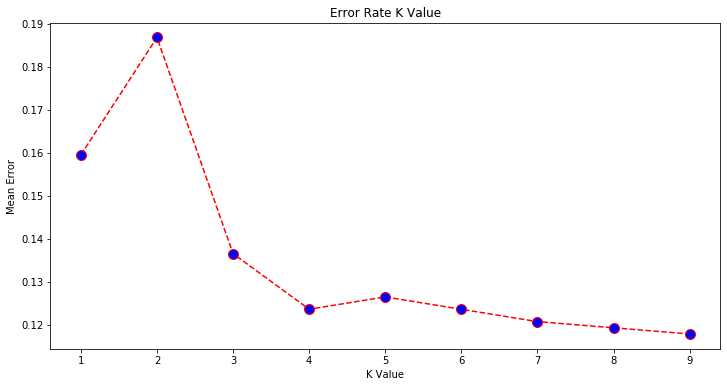

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

### Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
%%time
from sklearn.metrics import accuracy_score
dtree1 = DecisionTreeClassifier(criterion='gini')
dtree1.fit(X_train, Y_train).predict(X_test)
pred_gini = dtree1.predict(X_test)

Wall time: 7.98 ms


In [45]:
acc_dtree1 = accuracy_score(Y_test, pred_gini)
acc_dtree1

0.8347701149425287

In [46]:
acc_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='accuracy')
acc_dtree1
print(acc_dtree1.mean())
print(acc_dtree1.std())

0.8003020925434718
0.0045621519149985955


In [47]:
precision_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='precision_macro')
precision_dtree1
print(precision_dtree1.mean())
print(precision_dtree1.std())

0.8035139621331989
0.008926144332736023


In [48]:
recall_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='recall_macro')
recall_dtree1
print(recall_dtree1.mean())
print(recall_dtree1.std())

0.8048433578327906
0.0006007936455718115


In [49]:
f1_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='f1_macro')
f1_dtree1
print(f1_dtree1.mean())
print(f1_dtree1.std())

0.7852422507512359
0.0068949862868967005


In [50]:
print(confusion_matrix(Y_test, pred_gini))
print(classification_report(Y_test, pred_gini))

[[ 86   8   1   0   1   2   0]
 [ 11  57   2   2   2  15   5]
 [  1   7 105   3   0   0   4]
 [  0   2   0  90   0   0   1]
 [  2   0   0   2 104   0   0]
 [  3  16   4   0   0  70   5]
 [  1   6   0   0   0   9  69]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.83      0.88      0.85        98
      Normal_Weight       0.59      0.61      0.60        94
     Obesity_Type_I       0.94      0.88      0.91       120
    Obesity_Type_II       0.93      0.97      0.95        93
   Obesity_Type_III       0.97      0.96      0.97       108
 Overweight_Level_I       0.73      0.71      0.72        98
Overweight_Level_II       0.82      0.81      0.82        85

           accuracy                           0.83       696
          macro avg       0.83      0.83      0.83       696
       weighted avg       0.84      0.83      0.84       696



In [51]:
%%time
dtree2 = DecisionTreeClassifier(criterion='entropy')
dtree2.fit(X_train, Y_train).predict(X_test)
pred_entropy = dtree2.predict(X_test)

Wall time: 13 ms


In [52]:
acc_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='accuracy')
acc_dtree2
print(acc_dtree2.mean())
print(acc_dtree2.std())

0.7787238859202876
0.022421571252857323


In [53]:
precision_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='precision_macro')
precision_dtree2
print(precision_dtree2.mean())
print(precision_dtree2.std())

0.771268511587484
0.02111864186814285


In [54]:
recall_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='recall_macro')
recall_dtree2
print(recall_dtree2.mean())
print(recall_dtree2.std())

0.776251594895326
0.011116853117167204


In [55]:
f1_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='f1_macro')
f1_dtree2
print(f1_dtree2.mean())
print(f1_dtree2.std())

0.7713311602589575
0.019338718944601332


In [56]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 79  11   4   0   1   2   1]
 [  9  60   2   1   2  16   4]
 [  1   6 104   2   0   1   6]
 [  0   4   0  88   0   0   1]
 [  2   0   0   2 104   0   0]
 [  1  10   2   1   0  75   9]
 [  0   3   3   0   0  14  65]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.86      0.81      0.83        98
      Normal_Weight       0.64      0.64      0.64        94
     Obesity_Type_I       0.90      0.87      0.89       120
    Obesity_Type_II       0.94      0.95      0.94        93
   Obesity_Type_III       0.97      0.96      0.97       108
 Overweight_Level_I       0.69      0.77      0.73        98
Overweight_Level_II       0.76      0.76      0.76        85

           accuracy                           0.83       696
          macro avg       0.82      0.82      0.82       696
       weighted avg       0.83      0.83      0.83       696



### SVM

In [57]:
%%time
# RBF
from sklearn.svm import SVC
svc_rbf = SVC(kernel='rbf',random_state = 0)
svc_rbf.fit(X_train,Y_train).predict(X_test)
pred_rbf = svc_rbf.predict(X_test)

Wall time: 48.9 ms


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [58]:
acc_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='accuracy')
acc_rbf
print(acc_rbf.mean())
print(acc_rbf.std())

0.8634614316773238
0.012854281570186844


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [59]:
precision_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='precision_macro')
precision_rbf
print(precision_rbf.mean())
print(precision_rbf.std())

0.860083120657571
0.016229090666884997


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [60]:
recall_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='recall_macro')
recall_rbf
print(recall_rbf.mean())
print(recall_rbf.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.85815245559803
0.012821853459345634


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [61]:
f1_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='f1_macro')
f1_rbf
print(f1_rbf.mean())
print(f1_rbf.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8578018531319689
0.015088422750066461


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [62]:
print(confusion_matrix(Y_test, pred_rbf))
print(classification_report(Y_test, pred_rbf))

[[ 89   6   1   0   1   1   0]
 [  8  68   2   1   2  11   2]
 [  1   5 109   2   0   0   3]
 [  0   2   0  90   0   1   0]
 [  2   0   0   0 106   0   0]
 [  1   7   3   0   0  79   8]
 [  0   3   0   0   0  11  71]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.91      0.89        98
      Normal_Weight       0.75      0.72      0.74        94
     Obesity_Type_I       0.95      0.91      0.93       120
    Obesity_Type_II       0.97      0.97      0.97        93
   Obesity_Type_III       0.97      0.98      0.98       108
 Overweight_Level_I       0.77      0.81      0.79        98
Overweight_Level_II       0.85      0.84      0.84        85

           accuracy                           0.88       696
          macro avg       0.88      0.88      0.88       696
       weighted avg       0.88      0.88      0.88       696



In [63]:
%%time
#poly
svc_poly = svm.SVC(kernel='poly')
svc_poly.fit(X_train, Y_train).predict(X_test)
pred_poly= svc_poly.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 97.7 ms


In [64]:
acc_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='accuracy')
acc_poly
print(acc_poly.mean())
print(acc_poly.std())

0.8029658247799176
0.030643997438332862


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [65]:
precision_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='precision_macro')
precision_poly
print(precision_poly.mean())
print(precision_poly.std())

0.8030738039146609
0.0320192145283841


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [66]:
recall_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='recall_macro')
recall_poly
print(recall_poly.mean())
print(recall_poly.std())

0.7927850333906669
0.03264233251596882


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [67]:
f1_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='f1_macro')
f1_poly
print(f1_poly.mean())
print(f1_poly.std())

0.7919771606206479
0.03424625043556179


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [68]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 79  11   4   0   1   2   1]
 [  9  60   2   1   2  16   4]
 [  1   6 104   2   0   1   6]
 [  0   4   0  88   0   0   1]
 [  2   0   0   2 104   0   0]
 [  1  10   2   1   0  75   9]
 [  0   3   3   0   0  14  65]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.86      0.81      0.83        98
      Normal_Weight       0.64      0.64      0.64        94
     Obesity_Type_I       0.90      0.87      0.89       120
    Obesity_Type_II       0.94      0.95      0.94        93
   Obesity_Type_III       0.97      0.96      0.97       108
 Overweight_Level_I       0.69      0.77      0.73        98
Overweight_Level_II       0.76      0.76      0.76        85

           accuracy                           0.83       696
          macro avg       0.82      0.82      0.82       696
       weighted avg       0.83      0.83      0.83       696



In [69]:
%%time
#sigmoid
svc_sigmoid = svm.SVC(kernel='sigmoid')
svc_sigmoid.fit(X_train, Y_train).predict(X_test)
pred_sigmoid= svc_sigmoid.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 148 ms


In [70]:
acc_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='accuracy')
acc_sig
print(acc_sig.mean())
print(acc_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.09756948448852497
0.020045251815350943


In [71]:
precision_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='precision_macro')
precision_sig
print(precision_sig.mean())
print(precision_sig.std())

0.0914431534289125
0.0378808594757447


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:14

In [72]:
recall_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='recall_macro')
recall_sig
print(recall_sig.mean())
print(recall_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.09157485676038035
0.018144911099544175


In [73]:
f1_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='f1_macro')
f1_sig
print(f1_sig.mean())
print(f1_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.08030343375058469
0.02045676054755015


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 79  11   4   0   1   2   1]
 [  9  60   2   1   2  16   4]
 [  1   6 104   2   0   1   6]
 [  0   4   0  88   0   0   1]
 [  2   0   0   2 104   0   0]
 [  1  10   2   1   0  75   9]
 [  0   3   3   0   0  14  65]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.86      0.81      0.83        98
      Normal_Weight       0.64      0.64      0.64        94
     Obesity_Type_I       0.90      0.87      0.89       120
    Obesity_Type_II       0.94      0.95      0.94        93
   Obesity_Type_III       0.97      0.96      0.97       108
 Overweight_Level_I       0.69      0.77      0.73        98
Overweight_Level_II       0.76      0.76      0.76        85

           accuracy                           0.83       696
          macro avg       0.82      0.82      0.82       696
       weighted avg       0.83      0.83      0.83       696



### Naive Bayes

In [75]:
%%time
gnb = GaussianNB()
pred_gnb = gnb.fit(X_train, Y_train).predict(X_test)

Wall time: 6.98 ms


In [76]:
acc_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='accuracy')
acc_NB
print(acc_NB.mean())
print(acc_NB.std())

0.8132221282521134
0.017282088036994974


In [77]:
precision_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='precision_macro')
precision_NB
print(precision_NB.mean())
print(precision_NB.std())

0.805379990652655
0.020398371538921822


In [78]:
recall_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='recall_macro')
recall_NB
print(recall_NB.mean())
print(recall_NB.std())

0.8096040630553185
0.019414875281062036


In [79]:
f1_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='f1_macro')
f1_NB
print(f1_NB.mean())
print(f1_NB.std())

0.8023790588791723
0.02065560351508892


In [80]:
print(confusion_matrix(Y_test, pred_gnb))
print(classification_report(Y_test, pred_gnb))

[[ 90   5   1   0   1   1   0]
 [ 15  60   2   1   2  11   3]
 [  1   5 106   3   0   1   4]
 [  0   2   0  90   0   0   1]
 [  2   0   0   0 106   0   0]
 [  0  10   2   0   0  74  12]
 [  0   3   4   0   0  14  64]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.83      0.92      0.87        98
      Normal_Weight       0.71      0.64      0.67        94
     Obesity_Type_I       0.92      0.88      0.90       120
    Obesity_Type_II       0.96      0.97      0.96        93
   Obesity_Type_III       0.97      0.98      0.98       108
 Overweight_Level_I       0.73      0.76      0.74        98
Overweight_Level_II       0.76      0.75      0.76        85

           accuracy                           0.85       696
          macro avg       0.84      0.84      0.84       696
       weighted avg       0.85      0.85      0.85       696



### Ensemble model : Adaboost

In [81]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
clfa = clfa = AdaBoostClassifier(n_estimators = 5)
clfa.fit(X_train, Y_train).predict(X_test)

Wall time: 29.9 ms


array(['Overweight_Level_II', 'Obesity_Type_II', 'Obesity_Type_II',
       'Overweight_Level_II', 'Obesity_Type_II', 'Overweight_Level_II',
       'Obesity_Type_II', 'Overweight_Level_II', 'Overweight_Level_II',
       'Overweight_Level_II', 'Overweight_Level_II',
       'Overweight_Level_II', 'Obesity_Type_I', 'Overweight_Level_II',
       'Obesity_Type_II', 'Overweight_Level_II', 'Overweight_Level_II',
       'Overweight_Level_II', 'Obesity_Type_II', 'Obesity_Type_I',
       'Overweight_Level_II', 'Obesity_Type_II', 'Obesity_Type_II',
       'Overweight_Level_II', 'Overweight_Level_II', 'Obesity_Type_I',
       'Obesity_Type_II', 'Overweight_Level_II', 'Overweight_Level_II',
       'Overweight_Level_II', 'Obesity_Type_II', 'Obesity_Type_I',
       'Overweight_Level_II', 'Overweight_Level_II',
       'Overweight_Level_II', 'Obesity_Type_II', 'Overweight_Level_II',
       'Obesity_Type_II', 'Obesity_Type_II', 'Obesity_Type_II',
       'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_

In [82]:
acc_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'accuracy')
acc_clfa
print(acc_clfa.mean())
print(acc_clfa.std())

0.4113012937975456
0.08255767334800067


In [83]:
precision_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'precision_macro')
precision_clfa
print(precision_clfa.mean())
print(precision_clfa.std())

0.2490959783858039
0.13132257897040045


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [84]:
recall_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'recall_macro')
recall_clfa
print(recall_clfa.mean())
print(recall_clfa.std())

0.3816121080233983
0.08436555287545101


In [85]:
f1_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'f1_macro')
f1_clfa
print(f1_clfa.mean())
print(f1_clfa.std())

0.27462593827197573
0.10735089928219572


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Compare Algorithms

In [86]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#prepare configuration for cross validation test harness
seed = 7
#prepare models
models = []
models.append(('1NN', KNeighborsClassifier(n_neighbors = 1)))
models.append(('3NN', KNeighborsClassifier(n_neighbors = 3)))
models.append(('5NN', KNeighborsClassifier(n_neighbors = 5)))
models.append(('CART', DecisionTreeClassifier(criterion = 'gini')))
models.append(('InfGain', DecisionTreeClassifier(criterion = 'entropy')))
models.append(('NB', GaussianNB()))
models.append(('RBF', SVC(kernel='rbf')))
models.append(('Poly', SVC(kernel='poly')))
models.append(('Sigmoid', SVC(kernel='sigmoid')))
models.append(('AB', AdaBoostClassifier(n_estimators=5)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

In [87]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_test, Y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1NN: 0.813218 (0.014223)
3NN: 0.850575 (0.007326)
5NN: 0.856322 (0.008128)
CART: 0.791667 (0.002032)
InfGain: 0.798851 (0.011313)
NB: 0.813218 (0.011313)
RBF: 0.867816 (0.005376)
Poly: 0.783046 (0.025460)
Sigmoid: 0.091954 (0.016255)
AB: 0.408046 (0.063868)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

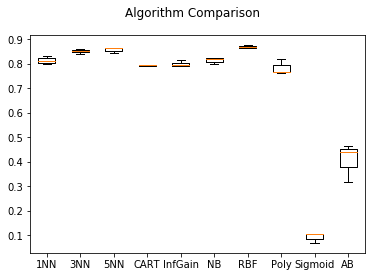

In [88]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()